## MNIST on TPU (Tensor Processing Unit)<br>or GPU using tf.Keras and tf.data.Dataset


This sample trains an "MNIST" handwritten digit 
recognition model on a GPU or TPU backend using a Keras
model. Data are handled using the tf.data.Datset API. This is
a very simple sample provided for educational purposes. Do
not expect outstanding TPU performance on a dataset as
small as MNIST.

<h3><a href="https://cloud.google.com/gpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/gpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Train on GPU or TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

  1. Select a GPU or TPU backend (Runtime > Change runtime type) 
  1. Runtime > Run All (Watch out: the "Colab-only auth" cell requires user input)

<h3><a href="https://cloud.google.com/ml-engine/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/mlengine-hexagon.png" width="50"></a>  &nbsp;&nbsp;Deploy to ML Engine</h3>
1. At the bottom of this notebook you can deploy your trained model to ML Engine for a serverless, autoscaled, REST API experience. You will need a GCP project and a GCS bucket for this last part.

TPUs are located in Google Cloud, for optimal performance, they read data directly from Google Cloud Storage (GCS)

### Parameters

In [0]:
BATCH_SIZE = 128

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

### Imports

In [0]:
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.platform import tf_logging
#from tensorflow.python.saved_model import builder as saved_model_builder
#from tensorflow.python.saved_model import signature_constants
#from tensorflow.python.saved_model import tag_constants
#from tensorflow.python.saved_model.signature_def_utils_impl import predict_signature_def

print("Tensorflow version " + tf.__version__)

Tensorflow version 1.13.0-rc1


### Colab-only auth for this notebook and the TPU

In [0]:
# backend identification
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
HAS_COLAB_TPU = 'COLAB_TPU_ADDR' in os.environ
USE_TPU = HAS_COLAB_TPU # TPU usage flag (change this if not running on Colab)

# Auth on Colab
# Little wrinkle: without auth, Colab will be extremely slow in accessing data from a GCS bucket, even public
if IS_COLAB_BACKEND:
  from google.colab import auth
  auth.authenticate_user()
  
# Also propagate the Auth to TPU so that it can access your GCS buckets
# This part is not important here since the TPU will be reading data from
# a public bucket but you will need it when your data is in your own bucket.
if IS_COLAB_BACKEND and HAS_COLAB_TPU:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
  with tf.Session(TF_MASTER) as sess:    
    with open('/content/adc.json', 'r') as f:
      auth_info = json.load(f) # Upload the credentials to TPU.
    tf.contrib.cloud.configure_gcs(sess, credentials=auth_info)
  print('Using TPU')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Using TPU


In [0]:
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  unbatched_train_ds = training_dataset.apply(tf.data.experimental.unbatch())
  v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
  t_images, t_labels = unbatched_train_ds.batch(N).make_one_shot_iterator().get_next()
  
  # Run once, get one batch. Session.run returns numpy results
  with tf.Session() as ses:
    (validation_digits, validation_labels,
     training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)
    
# utility to display training and validation curves
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.grid(linewidth=1, color='white')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

### tf.data.Dataset: parse files and prepare training and validation datasets
Please read the [best practices for building](https://www.tensorflow.org/guide/performance/datasets) input pipelines with tf.data.Dataset

In [0]:
def read_label(tf_bytestring):
    label = tf.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(10)  # fetch next batches while training on the current one
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# instantiate the datasets
training_dataset = get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

# For TPU, we will need a function that returns the dataset
training_input_fn = lambda: get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_input_fn = lambda: get_validation_dataset(validation_images_file, validation_labels_file)

### Let's have a look at the data

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


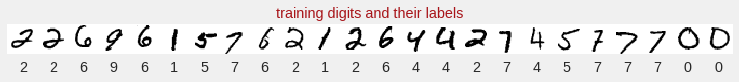

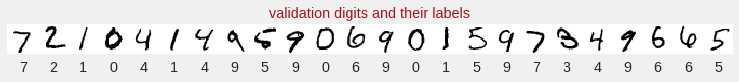

In [0]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

### Keras model: 3 convolutional layers, 2 dense layers
If you are not sure what cross-entropy, dropout, softmax or batch-normalization mean, head here for a crash-course: [Tensorflow and deep learning without a PhD](https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd/#featured-code-sample)

In [0]:
# This model trains to 99.4% sometimes 99.5% accuracy in 10 epochs (with a batch size of 32)

l = tf.keras.layers
model = tf.keras.Sequential(
  [
    l.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),

    l.Conv2D(filters=6, kernel_size=3, padding='same', use_bias=False), # no bias necessary before batch norm
    l.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
    l.Activation('relu'), # activation after batch norm

    l.Conv2D(filters=12, kernel_size=6, padding='same', use_bias=False, strides=2),
    l.BatchNormalization(scale=False, center=True),
    l.Activation('relu'),

    l.Conv2D(filters=24, kernel_size=6, padding='same', use_bias=False, strides=2),
    l.BatchNormalization(scale=False, center=True),
    l.Activation('relu'),

    l.Flatten(),
    l.Dense(200, use_bias=False),
    l.BatchNormalization(scale=False, center=True),
    l.Activation('relu'),
    l.Dropout(0.5), # Dropout on dense layer only

    l.Dense(10, activation='softmax')
  ])

model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# set up learning rate decay
lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.0001 + 0.02 * math.pow(0.5, 1+epoch), verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         54        
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 6)         18        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 12)        2592      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 12)        36        
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 12)        0         
__________

### Train and validate the model

In [0]:
EPOCHS = 10
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
trained_model = model

# Counting steps and batches on TPU: the tpu.keras_to_tpu_model API regards the batch size of the input dataset
# as the per-core batch size. The effective batch size is 8x more because Cloud TPUs have 8 cores. It increments
# the step by +8 everytime a global batch (8 per-core batches) is processed. Therefore batch size and steps_per_epoch
# settings can stay as they are for TPU training. The training will just go faster.
# Warning: this might change in the final version of the Keras/TPU API.

if USE_TPU:
  print('Using TPU')
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  # On a VM created using "ctpu up", you can use TPUClusterResolver(os.environ('TPU_NAME')) # The TPU name is usually the same as the name of your VM, use that if for some reason the TPU_NAME environment variable is not set
  strategy = tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER))
  trained_model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)
  # Work in progress: reading directly from dataset object not yet implemented
  # for Keras/TPU. Keras/TPU needs a function that returns a dataset
  history = trained_model.fit(training_input_fn, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                            validation_data=validation_input_fn, validation_steps=1, callbacks=[lr_decay])
else:
  history = trained_model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                              validation_data=validation_dataset, validation_steps=1, callbacks=[lr_decay])

Using TPU
INFO:tensorflow:Querying Tensorflow master (b'grpc://10.114.220.106:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2911285283579211199)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1284961179299033488)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 3443941261017588796)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 13782083442928953020)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 17647193668200979235)
INFO:tensorflow:*** Available Dev

### Visualize training and validation curves

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


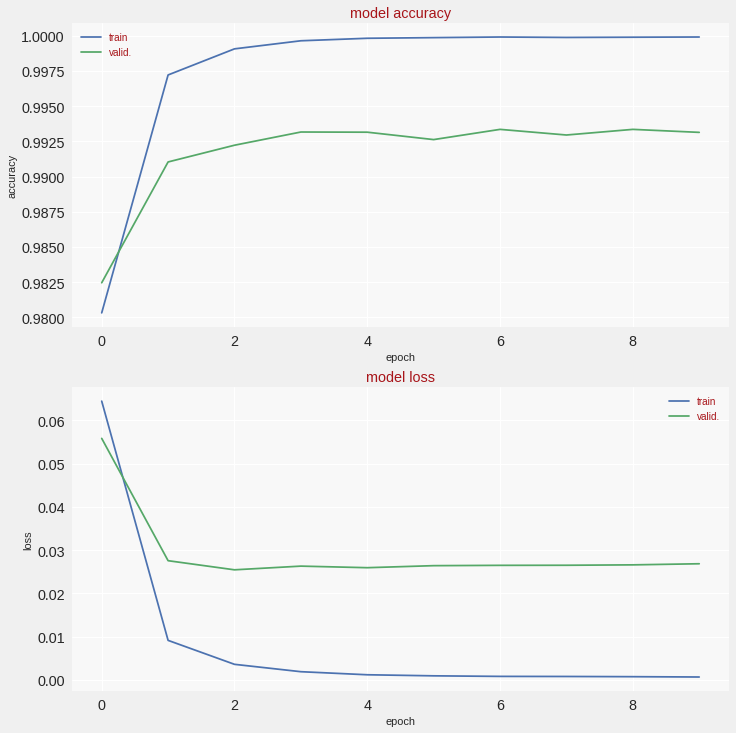

In [0]:
print(history.history.keys())
display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

### Visualize predictions

INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(3, 784), dtype=tf.float32, name='reshape_input_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.010099999606609344, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for reshape_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 1.583526372909546 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(1250, 784), dtype=tf.float32, name='reshape_input_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for reshape_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 1.4620962142944336 secs


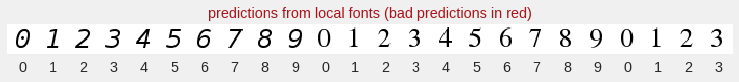

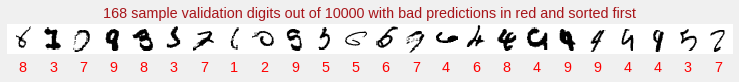

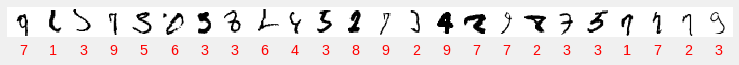

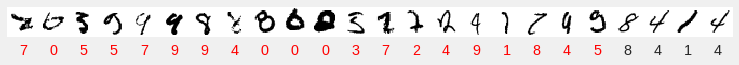

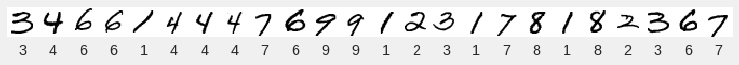

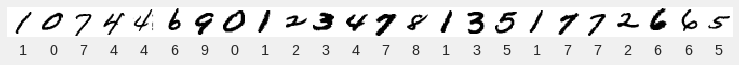

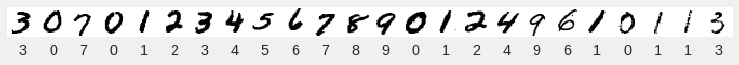

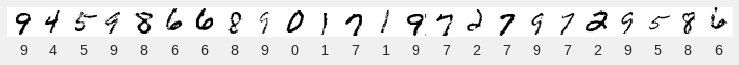

In [0]:
# recognize digits from local fonts
probabilities = trained_model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = trained_model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

## Deploy the trained model to ML Engine

Push your trained model to production on ML Engine for a serverless, autoscaled, REST API experience.

You will need a GCS bucket and a GCP project for this.
Models deployed on ML Engine autoscale to zero if not used. There will be no ML Engine charges after you are done testing.
Google Cloud Storage incurs charges. Empty the bucket after deployment if you want to avoid these. Once the model is deployed, the bucket is not useful anymore.

### Configuration

In [0]:
PROJECT = "xenon-hub-194919" #@param {type:"string"}
BUCKET = "gs://xenon-models"  #@param {type:"string", default:"jddj"}
NEW_MODEL = True #@param {type:"boolean"}
MODEL_NAME = "colabmnist" #@param {type:"string"}
MODEL_VERSION = "v0" #@param {type:"string"}

assert PROJECT, 'For this part, you need a GCP project. Head to http://console.cloud.google.com/ and create one.'
assert re.search(r'gs://.+', BUCKET), 'For this part, you need a GCS bucket. Head to http://console.cloud.google.com/storage and create one.'

### Export the model for serving from ML Engine

In [0]:
class ServingInput(tf.keras.layers.Layer):
  # the important detail in this boilerplate code is "trainable=False"
  def __init__(self, name, dtype, batch_input_shape=None):
    super(ServingInput, self).__init__(trainable=False, name=name, dtype=dtype, batch_input_shape=batch_input_shape)
  def get_config(self):
    return {'batch_input_shape': self._batch_input_shape, 'dtype': self.dtype, 'name': self.name }

  def call(self, inputs):
    # When the deployed model is called through its REST API,
    # the JSON payload is parsed automatically, transformed into
    # a tensor and passed to this input layer. You can perform
    # additional transformations, such as decoding JPEGs for example,
    # before sending the data to your model. However, you can only
    # use tf.xxxx operations.
    return inputs

# little wrinkle: must copy the model from TPU to CPU manually. This is a temporary workaround.
tf_logging.set_verbosity(tf_logging.INFO)
restored_model = model
restored_model.set_weights(trained_model.get_weights()) # this copied the weights from TPU, does nothing on GPU
tf_logging.set_verbosity(tf_logging.WARN)

# add the serving input layer
serving_model = tf.keras.Sequential()
serving_model.add(ServingInput('serving', tf.float32, (None, 28*28)))
serving_model.add(restored_model)

export_path = tf.contrib.saved_model.save_keras_model(serving_model, os.path.join(BUCKET, 'keras_export'))  # export he model to your bucket
export_path = export_path.decode('utf-8')
print("Model exported to: ", export_path)

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:TPU -> CPU lr: 0.00011953125067520887
INFO:tensorflow:TPU -> CPU beta_1: 0.8999999761581421
INFO:tensorflow:TPU -> CPU beta_2: 0.9990000128746033
INFO:tensorflow:TPU -> CPU decay: 0.0
INFO:tensorflow:TPU -> CPU epsilon: 1e-07
INFO:tensorflow:TPU -> CPU amsgrad: False
Model exported to:  gs://xenon-models/keras_export/1545961192


### Deploy the model
This uses the command-line interface. You can do the same thing through the ML Engine UI at https://console.cloud.google.com/mlengine/models


In [0]:
# Create the model
if NEW_MODEL:
  !gcloud ml-engine models create {MODEL_NAME} --project={PROJECT} --regions=us-central1

API [ml.googleapis.com] not enabled on project [1051181301589]. Would 
you like to enable and retry (this will take a few minutes)? (y/N)?  y

Enabling service [ml.googleapis.com] on project [1051181301589]...
Waiting for async operation operations/acf.2e5b9b22-04b9-42f8-a8d2-6c5a943ef9a4 to complete...
y
Operation finished successfully. The following command can describe the Operation details:
 gcloud services operations describe operations/tmo-acf.2e5b9b22-04b9-42f8-a8d2-6c5a943ef9a4
Created ml engine model [projects/xenon-hub-194919/models/colabmnist].


In [0]:
# Create a version of this model (you can add --async at the end of the line to make this call non blocking)
# Additional config flags are available: https://cloud.google.com/ml-engine/reference/rest/v1/projects.models.versions
# You can also deploy a model that is stored locally by providing a --staging-bucket=... parameter
!echo "Deployment takes a couple of minutes. You can watch your deployment here: https://console.cloud.google.com/mlengine/models/{MODEL_NAME}"
!gcloud ml-engine versions create {MODEL_VERSION} --model={MODEL_NAME} --origin={export_path} --project={PROJECT} --runtime-version=1.10

Deployment takes a couple of minutes. You can watch your deployment here: https://console.cloud.google.com/mlengine/models/colabmnist


### Test the deployed model
Your model is now available as a REST API. Let us try to call it. The cells below use the "gcloud ml-engine"
command line tool but any tool that can send a JSON payload to a REST endpoint will work.

In [0]:
# prepare digits to send to online prediction endpoint
digits = np.concatenate((font_digits, validation_digits[:100-N]))
labels = np.concatenate((font_labels, validation_labels[:100-N]))
with open("digits.json", "w") as f:
  for digit in digits:
    # the format for ML Engine online predictions is: one JSON object per line
    data = json.dumps({"serving_input": digit.tolist()})  # "serving_input" because the ServingInput layer was named "serving". Keras appends "_input"
    print(data, file=f)

['SEQUENTIAL', '[0.9999972581863403, 4.9489678848047e-12, 1.7940562813123506e-08, 1.7013407826657612e-12, 9.116770923259243e-13, 1.032395391398211e-09, 1.1616381101475781e-07, 1.2929110039527902e-11, 7.546113955925193e-09, 2.6636419079295592e-06]', '[6.17578835293564e-11, 0.9998794794082642, 0.00011996126704616472, 4.586671309425583e-08, 1.4398354730715823e-10, 7.732737117294164e-08, 7.947311558842429e-11, 3.971154285409284e-07, 1.829002921338585e-11, 1.0999793437216354e-10]', '[8.772483295338418e-10, 1.1797345045305718e-10, 0.9999998807907104, 4.896448402291753e-08, 4.03956754927836e-14, 2.5771762111534424e-13, 1.1700927770100233e-12, 5.978541217643851e-09, 6.073561564789998e-08, 1.214956607542561e-10]', '[8.809660135635937e-17, 1.1539622339282185e-12, 2.3219531766066615e-12, 1.0, 2.1053664614519912e-19, 5.2342120221426924e-11, 2.8840702576039252e-18, 5.756653400496026e-12, 4.0297352585892676e-13, 1.1984070149000797e-13]', '[5.28657839726776e-10, 9.866654160362032e-09, 4.4363652307310

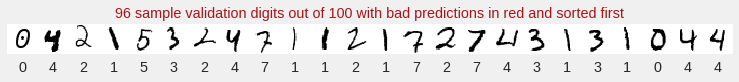

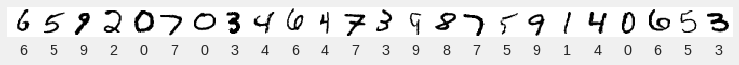

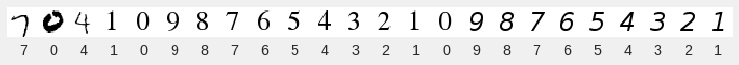

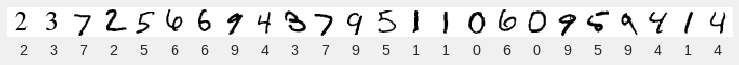

In [0]:
# Request online predictions from deployed model (REST API) using the "gcloud ml-engine" command line.
predictions = !gcloud ml-engine predict --model={MODEL_NAME} --json-instances digits.json --project={PROJECT} --version {MODEL_VERSION}
print(predictions)

probabilities = np.stack([json.loads(p) for p in predictions[1:]]) # first line is the name of the input layer: drop it, parse the rest
predictions = np.argmax(probabilities, axis=1)
display_top_unrecognized(digits, predictions, labels, N, 100//N)

## End